# Titanic Survival Prediction

## Table of Contents
1 [Project Summary](#summary)  
2 [Loading](#loading)  
2.1 [Import Libraries](#libraries)  
2.2 [Import Data](#data)  
2.3 [Functions](#function)  
3 [Exploring the data](#eda)  
3.1 [Data Overview](#overview)  
3.1.1 [Input Variables](#input)  
3.1.2 [Profile](#profile)  
3.2 [Data Cleaning](#cleaning)  
3.3 [Visualisation](#visualisation)  
3.4 [Feature Engineering](#feature)  
3.5 [Preprocessing](#preprocess)  
4 [Model Deployment](#modeldep)  
4.1 [Model Development](#developmodel)  
4.2 [Model Tuning](#modeltune)  
4.3 [Model Validation](#validate)  
5 [Deploy](#deploy)  
[Appendix](#Append)

# Project Summary
<a id="summary"></a>
***
**Situation**  
Titanic sank after colliding with an iceberg on 15th April 1912, resulting in the death of 1502 out of 2224 passengers and crew. Although there was a luck element to survive in this incident, it seems that some groups of people were more likely to survive than others. This project aims to find key elements related to survived groups and predict who can survive in the Titanic shipwreck.  
  
**Action and Goal**  
Using the passenger data provided from Kaggle, exploratory data analysis (EDA) and model deployment are implemented by using Python and jupyter notebook. The goal is to build a predictive model that answers the question: what kind of people/groups is more likely to survive?  Since the output from the model is expected to be binary (1:survived or 0:not survived), a binary model is needed to be built by exploring classification algorithms such as decision tree, random forest, support vector machine (SVM) and a neural network. The deployed model is evaluated by cross-validation and the result from the model is submitted to the Kaggle leaderboard.

# Loading
<a id="loading"></a>

## Import Libraries
<a id="libraries"></a>
***
These libraries can be installed from **Pipfile** and **Pipfile.lock** using pipenv (**Python version: 3.7.5**)

In [169]:
# ----------------------- Libraries required -----------------------
import sys, os
sys.path.append(os.pardir)
import math 
import warnings
warnings.filterwarnings('ignore')

# EDA / Data engineering
import numpy as np
import pandas as pd
import pandas_profiling as pdp

from sklearn import preprocessing

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
#import plotly

# Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC

import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# from keras.backend import tensorflow_backend as backend

import xgboost as XGB
import lightgbm as LGB

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline

# Validation/Model tuning
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

## Import Data
<a id="data"></a>
***
**Files in "data" directory:**  
  
- train.csv: training set

- test.csv: test set

(https://www.kaggle.com/c/titanic/data)

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Create df_full by concatenating df_train and df_test
df_test["Survived"] = np.nan
df_full = pd.concat([df_train, df_test], axis=0)
# df_full

## Functions
<a id="function"></a>

**Data Profile**
***
This function provides a summary of data structure in dataframe such as data types, count of the null data and count of the unique values. (See [Profile](#profile))

In [220]:
def data_profile(df):
    
    # Datatype
    df_dtype = pd.DataFrame(df.dtypes)
    
    # Null count
    df_null = pd.DataFrame(df.isnull().sum())
    # Null ratio (%)
    null_ratio = df.isnull().sum() / df.shape[0] * 100 #Percentage
    null_ratio = null_ratio.apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    df_null_ratio = pd.DataFrame(null_ratio)
    
    # Non-null count
    df_notnull = pd.DataFrame(df.notnull().sum())
    
    # Unique value/Unique ratio(%)
    df_unique = {}
    df_unique_ratio = {}
    
    for column in df.columns:
        df_unique[column] = len(df[column].value_counts())
        df_unique_ratio[column] = len(df[column].value_counts()) / df.shape[0] *100 #Percentage
        
    df_unique = pd.DataFrame.from_dict(df_unique, orient='index')
    df_unique_ratio = pd.DataFrame.from_dict(df_unique_ratio, orient='index')
    df_unique_ratio = df_unique_ratio[0].apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    
    # Create a new dataframe showing the data profile 
    df_profile = pd.concat([df_dtype, df_null, df_null_ratio, df_notnull, df_unique, df_unique_ratio], axis=1).reset_index()
    df_profile.columns = ['Column', 'Data type', 'Null count', 'Null ratio (%)', 'Non-null count', 'Distinct', 'Distinct (%)']
    
    return df_profile

**Get summry statistics of grouped data**
***
This function generates a dataframe as dictionary that contains summary statistics of grouped data.(See [](#))  
Also, see examples in [Appendix](#Append) A1.

In [4]:
def grouped_data_summary(df, group_by ,group_key, agg_functions, new_col_names):
    ''' Get summary statistics of grouped data
    
    Parameters
    ----------
    df (dataframe):
    group_by (list): 
    key (list): 
    agg_function: aggregation functions (sum, mean, max, min,...)
    
    Return
    ----------
    df_dict - modified dataframe in dictionary format
    '''
    
    # Create a dictinary
    df_dict = {}
    
    for group_name in group_by:
        # get the data based on group
        df_modi = (
            df.groupby(group_name)[group_key]
            .agg(agg_functions)
        )
        
        # Rename column names
        df_modi.columns = new_col_names
        
        # Reset index
        df_modi = df_modi.reset_index()
        
        # Store the results in the dictonary
        df_dict[group_name] = df_modi
    
    return df_dict

**Barplots**
***
***barplot_plt()*** generates bar chart(s) using ***matplotlib*** on a single plot or multiple plots. Dataframe must be dictionary format which is an output from ***groupby_summary()***

In [5]:
# Matplotlib
def barplot_plt(df, x_cols, y_col, plot_ax=0, fig_size_unit=[20,10]):
    """ Bar chart generated by matplotlib
    This plot can show multi panel plots
    
    Parameters
    ----------
    df (dataframe in dictionary)
    x_cols (list):
    y_col (string or list): ex) 'a' / ['a'] / ['a', 'b', 'c']
    plot_ax(0 or 1, Default:0)
    fig_size_unit: figure size per one figure
    """
    
    # check the input type of x_cols
    if  isinstance(x_cols, str):
        x_cols = [x_cols] #if the input is string, convert to list
    
    # Define figure size
    if plot_ax == 0:
        n_col = len(x_cols)
        n_row = 1
        fig_size = [fig_size_unit[0]*n_col, fig_size_unit[1]]
    
    elif plot_ax == 1:
        n_col = 1
        n_row = len(x_cols)
        fig_size = [fig_size_unit[0], fig_size_unit[1]*n_row]
        
    # Define subplot windows and axes
    fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
    plt.subplots_adjust(hspace=0.3)
    
        
    if len(x_cols) == 1: # single plot
        key = x_cols[0]
        
        x = df[key][key]
        y = df[key][y_col]
        axes.bar(x, y, tick_label=x, color=mcolors.TABLEAU_COLORS)
        axes.set_xlabel(key)
        axes.set_ylabel(y_col)
        
    else: # Multi plot
        for key, ax in zip(x_cols, axes):
            x = df[key][key]
            y = df[key][y_col]
            ax.bar(x, y, tick_label=x, color=mcolors.TABLEAU_COLORS)
            ax.set_xlabel(key)
            ax.set_ylabel(y_col)
        
    # show Figure
    plt.show()

***
***barplot_sns()*** generates bar chart(s) using ***seaborn*** on a single plot or multple plots. Dataframe must be dictionary format which is an output from ***groupby_summary()***

In [6]:
# Seaborn
def barplot_sns(df, x_cols, y_col, plot_ax=0, fig_size_unit=[20,10]):
    
    
    if  isinstance(x_cols, str):
        x_cols = [x_cols] #if the input is string, convert to list
    
    # Define figure size
    if plot_ax == 0:
        n_col = len(x_cols)
        n_row = 1
        fig_size = [fig_size_unit[0]*n_col, fig_size_unit[1]]
    
    elif plot_ax == 1:
        n_col = 1
        n_row = len(x_cols)
        fig_size = [fig_size_unit[0], fig_size_unit[1]*n_row]
        
    # Define subplot windows and axes
    fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
    plt.subplots_adjust(hspace=0.3)
    
    
    if len(x_cols) == 1: # single plot
        key = x_cols[0]
        
        sns.barplot(x=key, y=y_col, data=df[key]
                    , ax=axes, palette='Set1'
                   )
        
    else: # Multi plot
        for key, ax in zip(x_cols, axes):
            
            sns.barplot(x=key, y=y_col, data=df[key]
                        , ax=ax, palette='Set1'
                       )
    
    #Show plot
    plt.show()

# Exploring the Data
<a id="eda"></a>

## Data Overview
<a id="overview"></a>
***  

### Input variable
<a id="input"></a>
***
- survival: binary (1: survived, 0: not survived)

- Pclass: ticket class  
    1 = upper  
    2 = middle  
    3 = low  

- sex: sex

- Age: Age in years (fractional if less than 1. If the age is estimated, is it in the form of xx.5)

- sibsp: the nubmer of siblings / spouses aboard the Titanic
    Sibling = brother, sister, stepbrother, stepsister
    Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: the number of parents / children aboard the Titanic
    Parent = mother, father
    Child = daughter, son, stepdaughter, stepson
    Some children travelled only with a nanny, therefore parch=0 for them.

- ticket: ticket number

- fare: Passenger fare  

- cabin: Cabin number

- embarked: Port of embarkation  
    C = Cherbourg  
    Q = Queenstown  
    S = Southampton  

In [7]:
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [8]:
df_test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  Survived  
0  34.5      0      0   330911   7.8292   NaN        Q       NaN  
1  47.0      1      0   363272   7.0000   NaN        S       NaN  
2  62.0      0      0   240276   9.6875   NaN        Q       NaN  
3  27.0      0      0   315154   8.6625   NaN        S       NaN  
4  22.0      1      1  3101298  12.2875   NaN        S       NaN

In [9]:
df_train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Profiling
<a id="profile"></a>
***
***data_profile()*** function (defined on [Funcntion](#function) section above) is used for quick view of the data structure and missing data. Also, Profile report can be generated by ***pandas_profiling***.  

In [218]:
data_profile(df_train)

Column Data type  Null count  Null ratio (%)  Non-null count  \
0   PassengerId     int64           0            0.00             891   
1      Survived     int64           0            0.00             891   
2        Pclass     int64           0            0.00             891   
3          Name    object           0            0.00             891   
4           Sex    object           0            0.00             891   
5           Age   float64         177           19.86             714   
6         SibSp     int64           0            0.00             891   
7         Parch     int64           0            0.00             891   
8        Ticket    object           0            0.00             891   
9          Fare   float64           0            0.00             891   
10        Cabin    object         687           77.10             204   
11     Embarked    object           2            0.22             889   

    Distinct  Distinct (%)  
0        891        100.00  
1          2          0.22  
2          3          0.33  
3        891        100.00  
4          2          0.22  
5         88          9.87  
6          7          0.78  
7          7          0.78  
8        681         76.43  
9        248         27.83  
10       147         16.49  
11         3          0.33

In [219]:
data_profile(df_test)

Column Data type  Null count  Null ratio (%)  Non-null count  \
0   PassengerId     int64           0            0.00             418   
1        Pclass     int64           0            0.00             418   
2          Name    object           0            0.00             418   
3           Sex    object           0            0.00             418   
4           Age   float64          86           20.57             332   
5         SibSp     int64           0            0.00             418   
6         Parch     int64           0            0.00             418   
7        Ticket    object           0            0.00             418   
8          Fare   float64           1            0.23             417   
9         Cabin    object         327           78.22              91   
10     Embarked    object           0            0.00             418   
11     Survived   float64         418          100.00               0   

    Distinct  Distinct (%)  
0        418        100.00  
1          3          0.71  
2        418        100.00  
3          2          0.47  
4         79         18.89  
5          7          1.67  
6          8          1.91  
7        363         86.84  
8        169         40.43  
9         76         18.18  
10         3          0.71  
11         0          0.00

In [105]:
# Generate ProfileReport for train data (by pandas_profile)
pdp.ProfileReport(df_train)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [106]:
pdp.ProfileReport(df_test)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Visualisation
<a id="visualisation"></a>

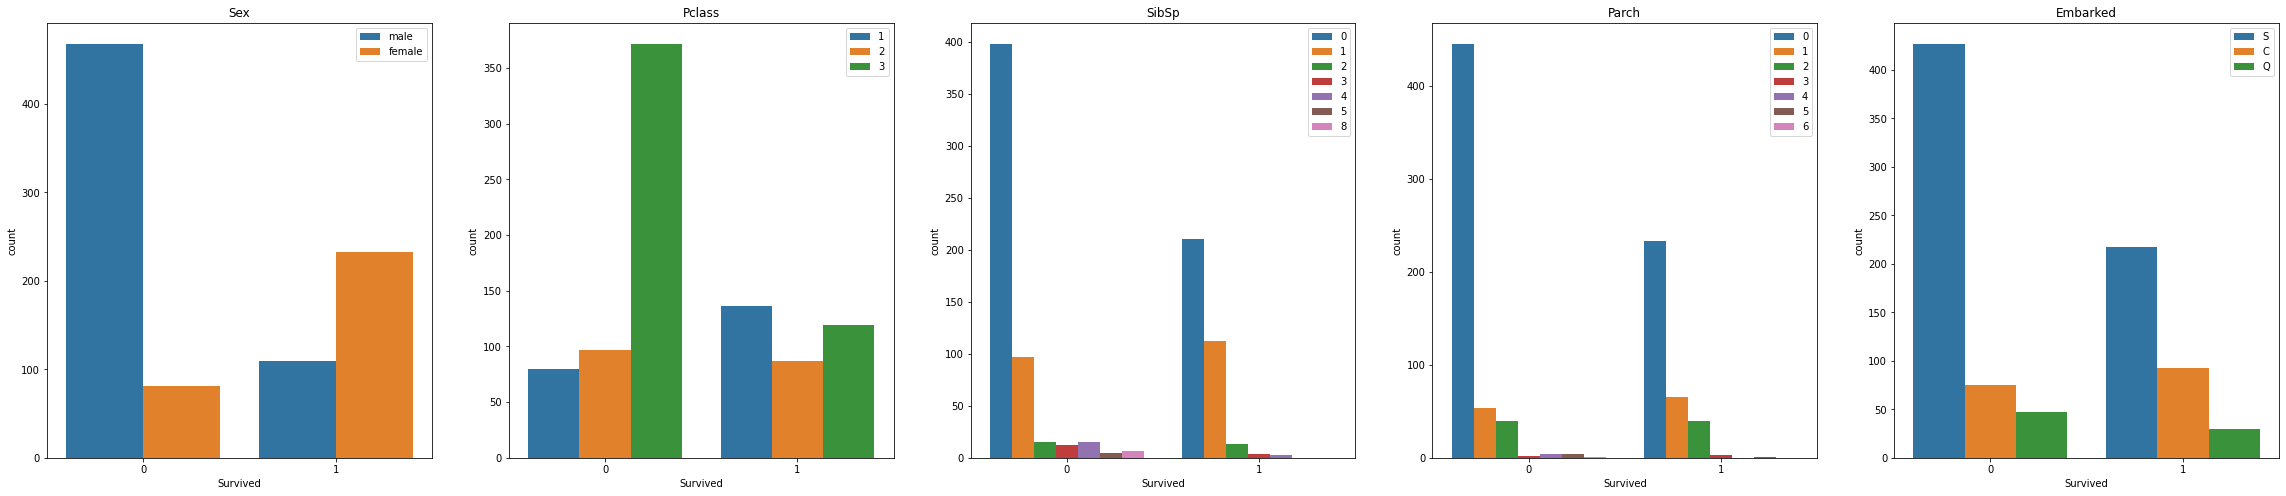

In [107]:
# Count plot (Survived(1) / not survived (0))
columns = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
df_train = pd.read_csv('data/train.csv')
fig, axes = plt.subplots(1, len(columns), figsize=(40, 8))
plt.subplots_adjust(hspace=0.3)

for column, ax in zip(columns, axes):
    sns.countplot(x='Survived', hue=column, data=df_train, ax=ax)
    ax.legend(loc='upper right')
    ax.set_title(column)

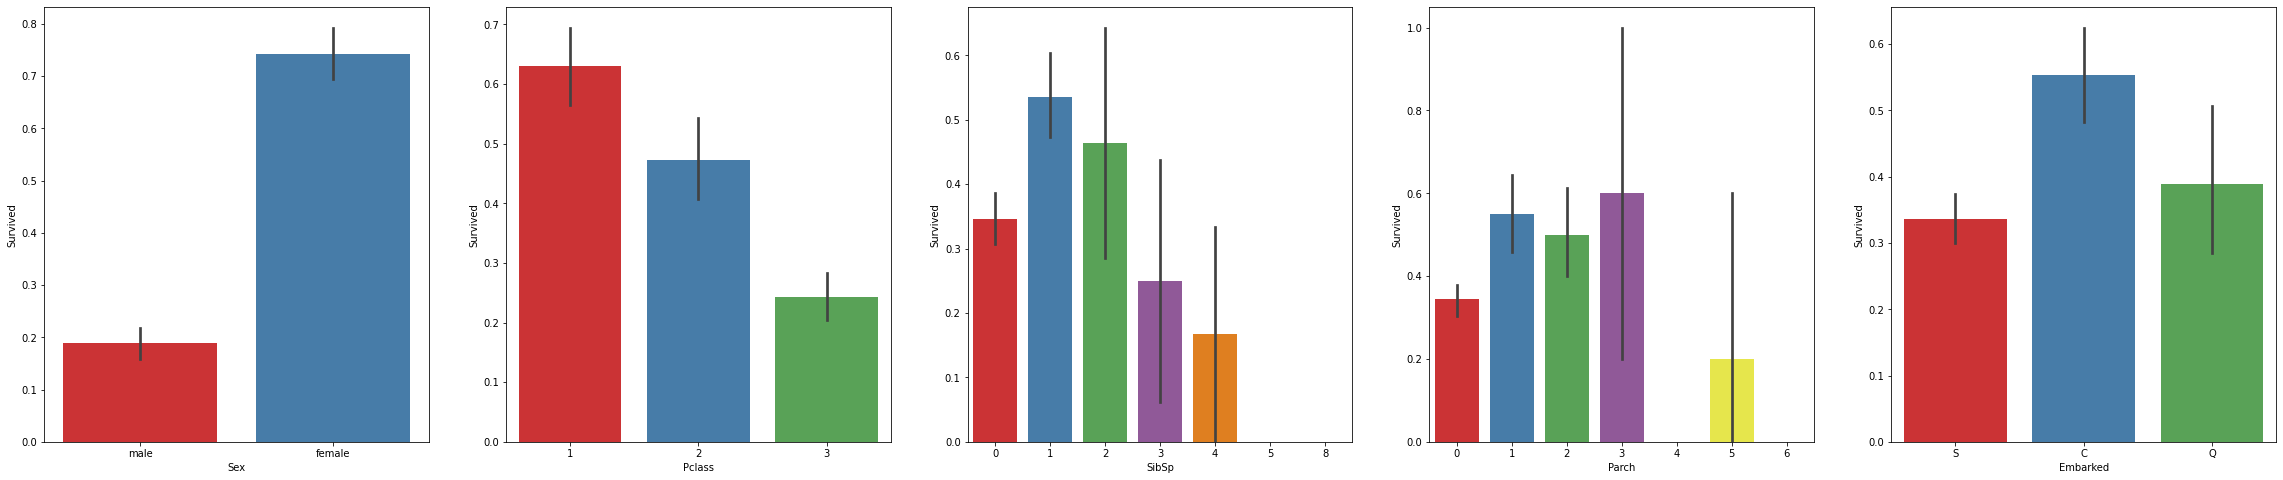

In [108]:
# Survival rate for each variable
fig, axes = plt.subplots(1, len(columns), figsize=(40, 8))
plt.subplots_adjust(hspace=0.3)

for column, ax in zip(columns, axes):
    sns.barplot(x=column, y='Survived', data=df_train, ax=ax, palette='Set1')
plt.show()

Cabin***
**Findings from ProfileReport generated by pandas_profiling and Survival rate plots**
- Age, Fare (in test data), Embarked, Cabin have missing cells. --> Imputation is required

- Strong correlation between Pclass and Fare

- Survival rate of female is much higher than male  

- Survival rate of upper class (1) is the highest

- The embarked S is the highest number --> ** "S" is used for imputation in "Embarked" 
***

# Preprocessing
<a id="preprocess"></a>
***


## Data Imputation

***
***
**Cabin**  
~80% of Cabin data is missing --> discarded from the analysis at this stage

***
***
**Embarked**  
The embarked S is the most frequent --> **"S"** is used for imputation in "Embarked" 

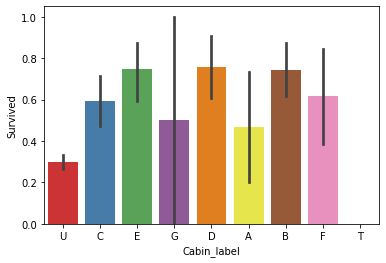

In [109]:
# Cabin
df_full['Cabin'] = df_full['Cabin'].fillna('Unknown')
df_full['Cabin_label']=df_full['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df_full, palette='Set1')
plt.show()

In [110]:
# Embarked
df_full["Embarked"] = df_full["Embarked"].fillna("S")

***
***
**Fare**  
Fare is correlated with Pclass and replace the missing values with median value of Fare in the same Pclass

In [111]:
# Passenger missing Fare value
df_full[df_full["Fare"].isnull()]

PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
152         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

     Parch Ticket  Fare    Cabin Embarked Cabin_label  
152      0   3701   NaN  Unknown        S           U

In [112]:
# Fare
fare=df_full.loc[(df_full['Embarked'] == 'S'), 'Fare'].median()
df_full['Fare']=df_full['Fare'].fillna(fare)
# df_full[df_full["Fare"].isnull()]

***
***
**Age**  
Age has correlation with some values.
In this analysis, Age is estimated from Pclass, Sex, Parch, SibSo using **Random Forest**.   

In [113]:
# Select variables for estiamtion
age_df = df_full[['Age', 'Pclass', 'Sex', 'Parch', 'SibSp']]

# One-hot encoding 
age_df=pd.get_dummies(age_df)

# divide the data into training data and test data
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# from training data, create X, Y
X = known_age[:, 1:]  
y = known_age[:, 0]

# Build a model using Random Forest
rfr = RFR(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# Predict unkown age and impute missing data
predictedAges = rfr.predict(unknown_age[:, 1::])
df_full.loc[(df_full.Age.isnull()), 'Age'] = predictedAges 

df_full

PassengerId  Survived  Pclass  \
0              1       0.0       3   
1              2       1.0       1   
2              3       1.0       3   
3              4       1.0       1   
4              5       0.0       3   
..           ...       ...     ...   
413         1305       NaN       3   
414         1306       NaN       1   
415         1307       NaN       3   
416         1308       NaN       3   
417         1309       NaN       3   

                                                  Name     Sex        Age  \
0                              Braund, Mr. Owen Harris    male  22.000000   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.000000   
2                               Heikkinen, Miss. Laina  female  26.000000   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.000000   
4                             Allen, Mr. William Henry    male  35.000000   
..                                                 ...     ...        ...   
413                                 Spector, Mr. Woolf    male  28.421211   
414                       Oliva y Ocana, Dona. Fermina  female  39.000000   
415                       Saether, Mr. Simon Sivertsen    male  38.500000   
416                                Ware, Mr. Frederick    male  28.421211   
417                           Peter, Master. Michael J    male  16.933814   

     SibSp  Parch              Ticket      Fare    Cabin Embarked Cabin_label  
0        1      0           A/5 21171    7.2500  Unknown        S           U  
1        1      0            PC 17599   71.2833      C85        C           C  
2        0      0    STON/O2. 3101282    7.9250  Unknown        S           U  
3        1      0              113803   53.1000     C123        S           C  
4        0      0              373450    8.0500  Unknown        S           U  
..     ...    ...                 ...       ...      ...      ...         ...  
413      0      0           A.5. 3236    8.0500  Unknown        S           U  
414      0      0            PC 17758  108.9000     C105        C           C  
415      0      0  SOTON/O.Q. 3101262    7.2500  Unknown        S           U  
416      0      0              359309    8.0500  Unknown        S           U  
417      1      1                2668   22.3583  Unknown        C           U  

[1309 rows x 13 columns]

**Visualise age distribution for survived/not survived group**

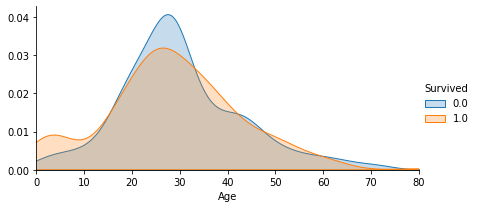

In [114]:
# Age distribution
facet = sns.FacetGrid(df_full[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_full.loc[:,'Age'].max()))
facet.add_legend()
plt.show()

## Feature Engineering
***


### Label ecoding

    - Age
    male: 0, female: 1  
      
    - Embarked
    Create one-hot data for each embarked place (Embarked -> Embarked_S, Embarked_Q, Embarked_C)

In [115]:
# ----------------- Label encodig -----------------
# labelEncoder = preprocessing.LabelEncoder()

# Sex
# df_full['Sex'] = df_full['Sex'].map({'male': 0, 'female': 1})

# Embarked
# Embarked_onehot = pd.get_dummies(df_full['Embarked'], prefix="Embarked")
# df_full = pd.concat((df_full, Embarked_onehot), axis=1)
# df_full.drop(['Embarked'], axis=1, inplace=True)
# df_full

### Create New Features
- FamilySize = SibSp + Parch + 1 

- FamilySurvived: Categorized FamilySize according to Survival rate 

- Title: Title exrtacted from name  

- Ticket label: Categorized Ticket according to survival rate

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

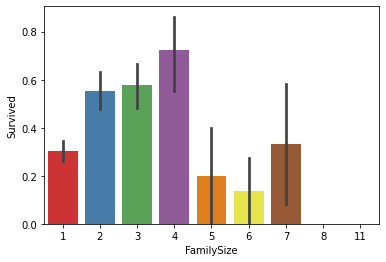

In [116]:
# ---- Family Size ---
df_full['FamilySize'] = df_full['SibSp'] + df_full['Parch'] + 1
df_plot = df_full[df_full['Survived'].notnull()]
# Survival rate
sns.barplot(x='FamilySize', y='Survived', data=df_plot, palette='Set1') 

In [117]:
# ---- Family Survival ----
#  Categorize FamilySize according to Survival rate 
# (high(FamilySize = 2-4): 2, low(FamilySize = 1, 5-7): 1, Zero (FamilySize>8): 0)
df_full.loc[(df_full['FamilySize']>=2) & (df_full['FamilySize']<=4), 'FamilySurvived'] = 2
df_full.loc[(df_full['FamilySize']>=5) & (df_full['FamilySize']<=7) | (df_full['FamilySize']==1), 'FamilySurvived'] = 1
df_full.loc[(df_full['FamilySize']>=8), 'FamilySurvived'] = 0

***
***
**Title extracted from name**

In [118]:
# ---- Name title ----
# Extract title from names
df_full['Title'] = df_full['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
pd.unique(df_full['Title'])

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

<AxesSubplot:xlabel='Title', ylabel='Survived'>

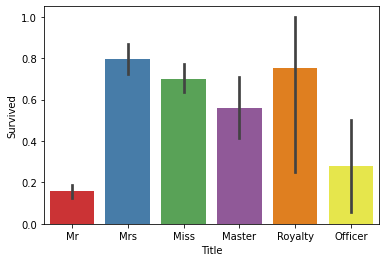

In [120]:
df_full['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df_full['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df_full['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df_full['Title'].replace(['Mlle'], 'Miss', inplace=True)
df_full['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df_full, palette='Set1')

***
***
**Surname**  
The passengers who have the same surname are in the same family group and probably their survival rate can be correlated. Insights obtained from the analysis above indicated that females or children under 16 years had more chance to be survived compared to mele or over 16 years old. 

In [121]:
# ---- Surname ----
df_full['Surname'] = df_full['Name'].map(lambda name:name.split(', ')[0].strip())
df_full['FamilyGroup'] = df_full['Surname'].map(df_full['Surname'].value_counts())

# Survival rate of MALE and over 16 years old in the family
Male_Adult = df_full.loc[(df_full['FamilyGroup'] >= 2) & (df_full['Age'] > 16) & (df_full['Sex'] == 'male')] # Sex:0 = male
Male_Adult_list = Male_Adult.groupby('Surname')['Survived'].mean()
print('Survived groups (Male and Adult)')
print(Male_Adult_list.value_counts())

# Survival rate of FEMALE and under 16 years old in the family
Female_Child = df_full.loc[(df_full['FamilyGroup'] >= 2) & (df_full['Age'] <= 16) | (df_full['Sex'] == 'female')] # Sex:1 = female
Female_Child_list = Female_Child.groupby('Surname')['Survived'].mean()
print('Survived groups (Female or Child)')
print(Female_Child_list.value_counts())

Survived groups (Male and Adult)
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64
Survived groups (Female or Child)
1.000000    206
0.000000     55
0.750000      2
0.142857      1
0.500000      1
0.333333      1
Name: Survived, dtype: int64


***
**Key Findings**

The analysis above shows 115 groups of Male and Adult was not survived, but 21 passengers could be survived. At the same time, while the majority of groups of female and children were survived, some groups could not survived.  
Based on this insight, two lists are created:  
  
- Dead_list: list of surnames for groups that are of female and children but anyone could not be survived.  

- Survived_list: list of surnames of groups that are of male and adults but all could be survived.  
Base on these list, the information of the training set is replaced to typical information of survived/not survived passengers.  
  
**This method can simplify the estimation model**
***

In [122]:
# Create Dead list and Survived list
Dead_list=set(Female_Child_list[Female_Child_list.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_list[Male_Adult_list.apply(lambda x:x==1)].index)

print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# Based on dead/survived list, repalce Sex, Age, Title to typiocal data for each case 
df_full.loc[(df_full['Survived'].isnull()) & (df_full['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df_full.loc[(df_full['Survived'].isnull()) & (df_full['Surname'].apply(lambda x:x in Survived_list)),
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

Dead_list =  {'Isham', 'Pettersson', 'Peters', 'Henry', 'Arnold-Franchi', 'Lahtinen', 'Strom', 'Lindahl', 'Barbara', 'Lindblom', 'Olsson', 'Cacic', 'Haas', 'Lobb', 'Panula', 'Vestrom', 'Ahlin', 'Ford', 'Hegarty', 'Canavan', 'Sage', 'Laitinen', 'Funk', 'Harknett', "O'Sullivan", 'Petranec', 'Lefebre', 'Goodwin', 'Attalah', 'Rosblom', 'Palsson', 'Rice', 'Bourke', 'Yrois', 'Dahlberg', 'Meanwell', 'Ilmakangas', 'Jussila', 'Mangan', 'Meek', 'Robins', 'Johnston', 'Strandberg', 'Boulos', 'Skoog', 'Danbom', 'Heininen', 'Oreskovic', 'Zabour', 'Vander Planke', 'Caram', 'Elias', 'Mack', 'Turpin', 'Van Impe'}
Survived_list =  {'Beckwith', 'Chambers', 'Kimball', 'Bishop', 'Goldenberg', 'Dick', 'Frauenthal', 'Cardeza', 'Daly', 'Duff Gordon', 'Frolicher-Stehli', 'Moubarek', 'Jonsson', 'Greenfield', 'Beane', 'Taylor', 'Bradley', 'Jussila', 'Harder', 'Nakid', 'McCoy'}


***
***
**Ticket**  
The same Ticket number represents the passengers in the same room who may had the same destiny.

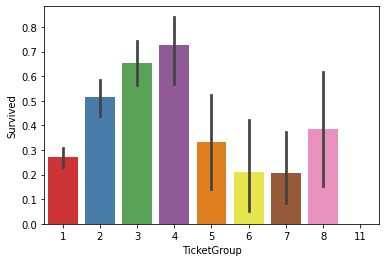

In [123]:
# Ticket
# Ticket group calculates the number of passengers who have the same ticket number
Ticket_Count = dict(df_full['Ticket'].value_counts())
df_full['TicketGroup'] = df_full['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df_full, palette='Set1')
plt.show()

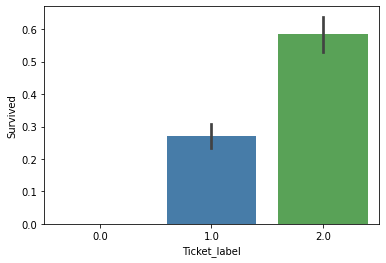

In [124]:
# Creates groups according to Survival Rate
df_full.loc[(df_full['TicketGroup']>=2) & (df_full['TicketGroup']<=4), 'Ticket_label'] = 2
df_full.loc[(df_full['TicketGroup']>=5) & (df_full['TicketGroup']<=8) | (df_full['TicketGroup']==1), 'Ticket_label'] = 1  
df_full.loc[(df_full['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df_full, palette='Set1')
plt.show()

## pre-processing

In [125]:
df_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_label',
       'FamilySize', 'FamilySurvived', 'Title', 'Surname', 'FamilyGroup',
       'TicketGroup', 'Ticket_label'],
      dtype='object')

In [126]:
# Select features used in estimation
df_full = df_full[['Survived', 'Embarked', 'Age', 'Fare','Pclass', 'Sex', 'Cabin_label', 'FamilySurvived', 'Title', 'Ticket_label']]

# One-hot encoding
df_full =pd.get_dummies(df_full)


# Split dataframe into train and test dataset
train = df_full[df_full['Survived'].notnull()]
test  = df_full[df_full['Survived'].isnull()].drop('Survived', axis=1) 

# Transform dataframe to numpy
X = train.values[:,1:] # Feature variable
y = train.values[:,0] # Survived label (0 or 1)
X_test = test.values 

# Model Development
<a id="modeldep"></a>
***

## Model Development
<a id="developmodel"></a>

In [127]:
train.columns

Index(['Survived', 'Age', 'Fare', 'Pclass', 'FamilySurvived', 'Ticket_label',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Cabin_label_A', 'Cabin_label_B', 'Cabin_label_C', 'Cabin_label_D',
       'Cabin_label_E', 'Cabin_label_F', 'Cabin_label_G', 'Cabin_label_T',
       'Cabin_label_U', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty'],
      dtype='object')

In [159]:

Seed = 10

# Linear Regression
linR = LinearRegression()

# Logistic Regression
logR = LogisticRegression()

# Extra Tree Classifier
etc = ETC(random_state=Seed
        , n_estimators=26
        , max_depth=8
        , min_samples_leaf=2
        , verbose=0
        )
# Random Forest Classifier
rfc = RFC(random_state = Seed
        , warm_start = True
        , n_estimators = 26
        , max_depth = 6
        , max_features = 'sqrt'
        )

# Gradient Boosting
gbc = GBC(random_state=Seed
        , max_depth=5
        , min_samples_leaf=2
        , verbose=0
        ) 

# #LightGBM
# lgb = LGB(task='train'
#         , boosting_type='gbdt'
#         , objective='regression'
#         , metric={'l2'}
#         , num_leaves=200
#         , learning_rate=0.003
#         , num_iterations=100
#         , feature_fraction=0.52
#         , bagging_fraction=0.79
#         , bagging_freq=7
#         , verbose=0
#         )

# Support Vector Classifier
svc = SVC(kernel='linear'
        , C=0.025
        )



clfs = {'linear_regression': linR
        , 'logistic_regression': logR
        , 'extra_trees': etc
        , 'random_forest': rfc
        , 'gradient_boosting': gbc
        # ,'ada_boost': AdaBoostClassifier(random_state=0)
        , 'support_vector':svc
        # ,'xgboost': XGBClassifier(random_state=0)
}

In [165]:
# Select features
select = SelectKBest(k=20)
scores = {}
predictions = {}
for key in clfs.keys():                
    pipeline = make_pipeline(select, clfs[key])
    pipeline.fit(X, y)
    cv_result = cross_validate(pipeline, X, y, cv= 10)
    print(key)
    print('mean_score = ', np.mean(cv_result['test_score']))
    print('mean_std = ', np.std(cv_result['test_score']))
    scores[key] = np.mean(cv_result['test_score'])
    mask= select.get_support()
    list_col = list(df_full.columns[1:])
    print(mask)
    df_feature = pd.DataFrame({'features': train.columns[1:][mask]})
    if (key is not 'linear_regression') & (key is not 'logistic_regression') & (key is not 'support_vector'):
        X_fit = train[train.columns[1:][mask==True]].values
        df_feature[key] = clfs[key].fit(X_fit,y).feature_importances_
    predictions[key] = pipeline.predict(X_test)

linear_regression
mean_score =  0.3754843912133012
mean_std =  0.09419436682525505
[ True  True  True  True  True  True False  True  True  True False  True
  True  True  True  True False False  True  True  True  True  True False
  True]
logistic_regression
mean_score =  0.8047815230961298
mean_std =  0.03616451551236523
[ True  True  True  True  True  True False  True  True  True False  True
  True  True  True  True False False  True  True  True  True  True False
  True]
extra_trees
mean_score =  0.837278401997503
mean_std =  0.03988291016596634
[ True  True  True  True  True  True False  True  True  True False  True
  True  True  True  True False False  True  True  True  True  True False
  True]
random_forest
mean_score =  0.8193133583021224
mean_std =  0.03966023339892623
[ True  True  True  True  True  True False  True  True  True False  True
  True  True  True  True False False  True  True  True  True  True False
  True]
gradient_boosting
mean_score =  0.8384394506866417
mean_std =

In [166]:
scores

{'linear_regression': 0.3754843912133012,
 'logistic_regression': 0.8047815230961298,
 'extra_trees': 0.837278401997503,
 'random_forest': 0.8193133583021224,
 'gradient_boosting': 0.8384394506866417,
 'support_vector': 0.786729088639201}

In [131]:
df_feature

features
0              Age
1             Fare
2           Pclass
3   FamilySurvived
4     Ticket_label
5       Embarked_C
6       Embarked_S
7       Sex_female
8         Sex_male
9    Cabin_label_B
10   Cabin_label_C
11   Cabin_label_D
12   Cabin_label_E
13   Cabin_label_F
14   Cabin_label_U
15    Title_Master
16      Title_Miss
17        Title_Mr
18       Title_Mrs
19   Title_Royalty

In [132]:
print('discarded features:'+str(train.columns[1:][np.logical_not(mask)]))

discarded features:Index(['Embarked_Q', 'Cabin_label_A', 'Cabin_label_G', 'Cabin_label_T',
       'Title_Officer'],
      dtype='object')


### Neural Network / Deep Learning
<a id="deeplearning"></a>
***

**Keras**

In [133]:
# Initialize model
nn_model = Sequential()
# Build layers
nn_model.add(Dense(12, activation='relu', input_dim=20))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(8, activation='relu'))
nn_model.add(Dense(5, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# model deployment
nn_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics='acc')

# Show build model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                252       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 407
Trainable params: 407
Non-trainable params: 0
_________________________________________________________________


In [134]:
x_train = train[train.columns[1:][mask]]
x_train_nn = x_train.values

In [135]:
log = nn_model.fit(x_train, y, epochs=5000, batch_size=32,verbose=1,
                callbacks=[EarlyStopping(monitor='val_loss',min_delta=0,patience=100,verbose=1)],
                validation_split=0.3)

Epoch 1/5000
20/20 [==============================] - 1s 13ms/step - loss: 0.7210 - acc: 0.5957 - val_loss: 0.6907 - val_acc: 0.6418
Epoch 2/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.7144 - acc: 0.5842 - val_loss: 0.6886 - val_acc: 0.6418
Epoch 3/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6995 - acc: 0.5773 - val_loss: 0.6869 - val_acc: 0.6418
Epoch 4/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.6868 - acc: 0.6161 - val_loss: 0.6851 - val_acc: 0.6418
Epoch 5/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6746 - acc: 0.6054 - val_loss: 0.6826 - val_acc: 0.6418
Epoch 6/5000
20/20 [==============================] - 0s 19ms/step - loss: 0.6821 - acc: 0.5877 - val_loss: 0.6465 - val_acc: 0.6418
Epoch 7/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6610 - acc: 0.5998 - val_loss: 0.6125 - val_acc: 0.6418
Epoch 8/5000
20/20 [==============================] - 0s 3ms/step - loss: 

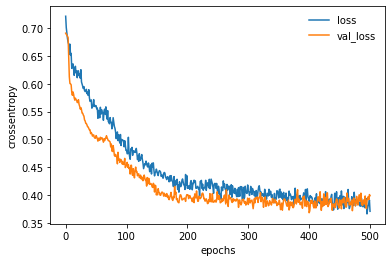

In [136]:
# Monitoring Learning steps
plt.plot(log.history['loss'],label='loss')
plt.plot(log.history['val_loss'],label='val_loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('crossentropy')
plt.show()

In [137]:
# Prediction
test_nn = test[test.columns[:][mask]]
test_nn

Age      Fare  Pclass  FamilySurvived  Ticket_label  Embarked_C  \
0    34.500000    7.8292       3             1.0           1.0           0   
1    47.000000    7.0000       3             2.0           1.0           0   
2    62.000000    9.6875       2             1.0           1.0           0   
3    27.000000    8.6625       3             1.0           1.0           0   
4    22.000000   12.2875       3             2.0           2.0           0   
..         ...       ...     ...             ...           ...         ...   
413  28.421211    8.0500       3             1.0           1.0           0   
414  39.000000  108.9000       1             1.0           2.0           1   
415  38.500000    7.2500       3             1.0           1.0           0   
416  28.421211    8.0500       3             1.0           1.0           0   
417  16.933814   22.3583       3             2.0           2.0           1   

     Embarked_S  Sex_female  Sex_male  Cabin_label_B  Cabin_label_C  \
0             0           0         1              0              0   
1             1           1         0              0              0   
2             0           0         1              0              0   
3             1           0         1              0              0   
4             1           1         0              0              0   
..          ...         ...       ...            ...            ...   
413           1           0         1              0              0   
414           0           1         0              0              1   
415           1           0         1              0              0   
416           1           0         1              0              0   
417           0           0         1              0              0   

     Cabin_label_D  Cabin_label_E  Cabin_label_F  Cabin_label_U  Title_Master  \
0                0              0              0              1             0   
1                0              0              0              1             0   
2                0              0              0              1             0   
3                0              0              0              1             0   
4                0              0              0              1             0   
..             ...            ...            ...            ...           ...   
413              0              0              0              1             0   
414              0              0              0              0             0   
415              0              0              0              1             0   
416              0              0              0              1             0   
417              0              0              0              1             1   

     Title_Miss  Title_Mr  Title_Mrs  Title_Royalty  
0             0         1          0              0  
1             0         0          1              0  
2             0         1          0              0  
3             0         1          0              0  
4             0         0          1              0  
..          ...       ...        ...            ...  
413           0         1          0              0  
414           0         0          0              1  
415           0         1          0              0  
416           0         1          0              0  
417           0         0          0              0  

[418 rows x 20 columns]

In [138]:
# Prediction using built neural network
prediction_nn = nn_model.predict_classes(test_nn)
prediction_nn = prediction_nn.reshape(-1)
# prediction_nn

/home/shota/Documents/MyProjects/Titanic-Survival-Prediction/.venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**TensorFlow**
<a id="tf"></a>

In [139]:
# Parameteres
learning_rate = 0.01
training_epochs = 10
batch_size = 32
display_step = 1
train_size = 800
step_size = 1000

n_input = 20
n_hidden_1 = 64
n_hidden_2 = 64
n_classes = 2 # number of classes to be classified (binary model = 2)

## Model Tuning
<a id="modeltune"></a>

In [153]:
# Grid search
# Create grid
n_estimators = [1, 5, 10, 20, 25, 50]
max_depth = [None, 5, 10, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [154]:
grid = GridSearchCV(estimator=rfc
                    , param_grid=param_grid
                    , cv=3
                    , verbose=2
                    , n_jobs=-1
                   )

grid_result = grid.fit(X, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [163]:
rfc_best = grid_result.best_estimator_
rfc_best

RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=5,
                       random_state=10, warm_start=True)

In [156]:
grid_result.best_score_

0.8350168350168351

After model tuning for Random forest, 

## Model Validation
<a id="validate"></a>

# Deploy
<a id="deploy"></a>

In [161]:
BestModel = 'random_forest'
BestPrediction = predictions[BestModel]
PassengerId = df_test['PassengerId']
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": BestPrediction.astype(np.int32)})
submission.to_csv("results/Titianic_RDF_model.csv", index=False)

In [143]:
PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [144]:
submission_nn = pd.DataFrame({"PassengerId": PassengerId, "Survived": prediction_nn.astype(np.int32)})
submission_nn.to_csv("results/Titianic_NN_model.csv", index=False)

# Appendix
<a id="Append"></a>

## A1. Examples of output from functions

### *grouped_data_summary()*

In [142]:
# Dataframe
df_cp = df_train.copy()
# Parameters
group_by = ['Sex', 'Pclass']
group_key = ['Survived']
agg_functions=['sum', 'mean']
column_names = ['Counts', 'Percentage']
# Get new dataframe in a dictionary
df_summary = grouped_data_summary(df_cp, group_by, group_key, agg_functions, column_names)

In [143]:
df_summary['Sex']

Sex  Counts  Percentage
0  female     233    0.742038
1    male     109    0.188908

In [11]:
df_summary['Pclass']

Pclass  Counts  Percentage
0       1     136    0.629630
1       2      87    0.472826
2       3     119    0.242363

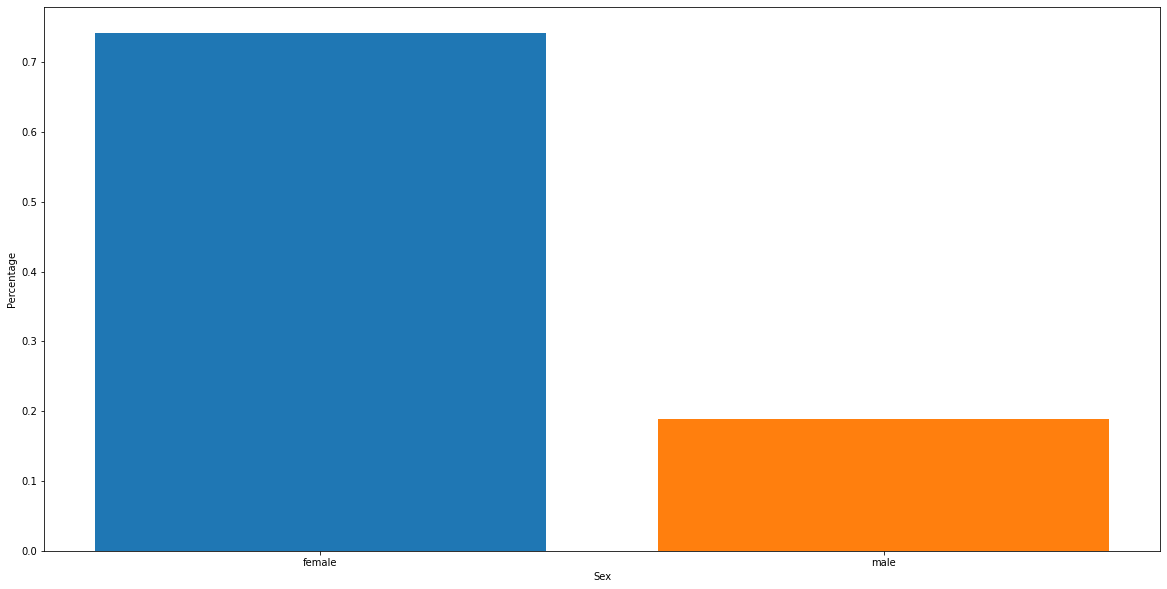

In [155]:
barplot_plt(df_summary, 'Sex', 'Percentage', plot_ax=1)

In [1]:
barplot_sns(df_summary, ['Sex', "Pclass"], 'Counts', plot_ax=1)

NameError: name 'barplot_plt' is not defined